# HOME CREDIT SCORECARD MODEL
## FINAL PROJECT RAKAMIN PROJECT BASED INTERNSHIP

### BACKGROUND
Home Credit saat ini sedang menggunakan berbagai macam metode statistik dan Machine Learning untuk membuat prediksi skor kredit. Sekarang, kami meminta anda untuk membuka potensi maksimal dari data kami. Dengan melakukannya, kita dapat memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman datap diberikan dengan principal, maturity, dan repayment calendar yang akan memotivsi pelanggan untuk sukses.

#### Objective
- memastikan pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman 
- pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar 
- Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

### IMPORT LIBRARY

In [1]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter('ignore')


# keras libraries
import tensorflow
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.backend import clear_session

# sklearn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# imblearn libraries
from imblearn.over_sampling import SMOTE

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

READ DATA

In [2]:
df_train = pd.read_csv('../Dataset/application_train.csv')
df_test = pd.read_csv('../Dataset/application_test.csv')
df_column_desc = pd.read_csv('../Dataset/HomeCredit_columns_description.csv', encoding='latin-1')
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


DESCRIBE

In [3]:
# Checknull
df_train.info()
print(df_train.isnull().sum())

# Print the count of columns
num_columns = df_train.shape[1]
print(f"Number of columns: {num_columns}")

# Print the count of rows
num_rows = df_train.shape[0]
print(f"Number of rows: {num_rows}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
Number of columns: 122
Number of rows: 307511


In [4]:
Column_Train = df_column_desc[df_column_desc['Table'] == 'application_{train|test}.csv']
column_train = Column_Train[['Row','Description']]
column_train

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


Check if any innapropriate input

In [5]:
#Unique Of Each Column
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()

Unique values in column 'SK_ID_CURR':
[100002 100003 100004 ... 456253 456254 456255]

Unique values in column 'TARGET':
[1 0]

Unique values in column 'NAME_CONTRACT_TYPE':
['Cash loans' 'Revolving loans']

Unique values in column 'CODE_GENDER':
['M' 'F' 'XNA']

Unique values in column 'FLAG_OWN_CAR':
['N' 'Y']

Unique values in column 'FLAG_OWN_REALTY':
['Y' 'N']

Unique values in column 'CNT_CHILDREN':
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]

Unique values in column 'AMT_INCOME_TOTAL':
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]

Unique values in column 'AMT_CREDIT':
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]

Unique values in column 'AMT_ANNUITY':
[24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5]

Unique values in column 'AMT_GOODS_PRICE':
[ 351000.  1129500.   135000.  ...  453465.   143977.5  743863.5]

Unique values in column 'NAME_TYPE_SUITE':
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group

DATA VISUALIZATION

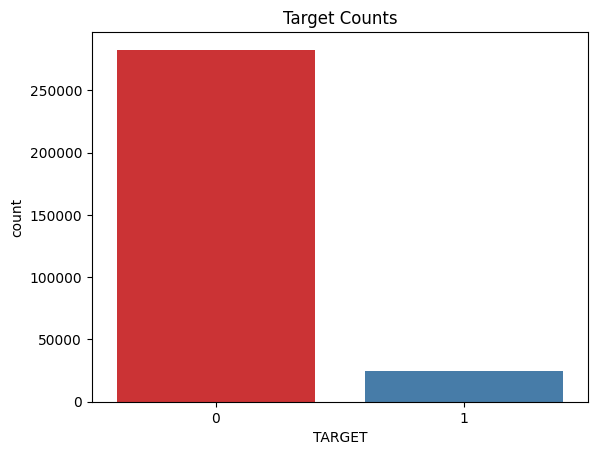

Target Counts:
0    282686
1     24825
Name: TARGET, dtype: int64


In [6]:
sns.countplot(x='TARGET',data=df_train,palette='Set1')
plt.title('Target Counts')
plt.show()
targetcounts = df_train['TARGET'].value_counts()

# Display the counts
print("Target Counts:")
print(targetcounts)

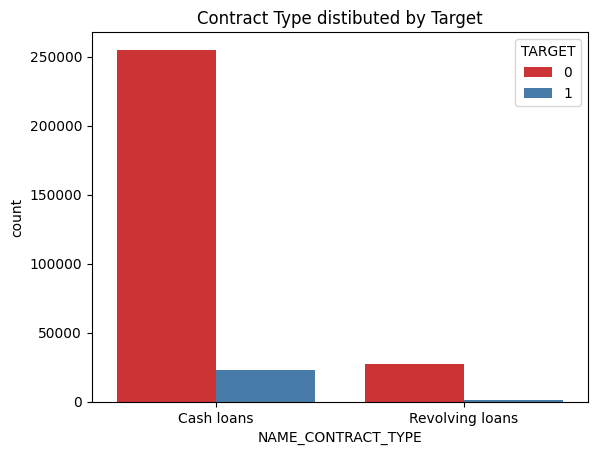

Target Counts:
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


In [7]:
sns.countplot(x='NAME_CONTRACT_TYPE',data=df_train, hue="TARGET",palette='Set1')
plt.title('Contract Type distibuted by Target')
plt.show()
val_count = df_train['NAME_CONTRACT_TYPE'].value_counts()

# Display the counts
print("Target Counts:")
print(val_count)

Gender Counts:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


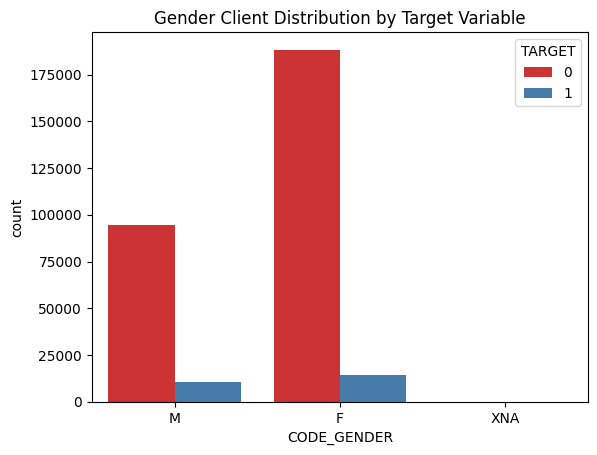

In [8]:
sns.countplot(data=df_train, x='CODE_GENDER', hue='TARGET', palette='Set1')
plt.title('Gender Client Distribution by Target Variable')
# Count occurrences of each gender
gender_counts = df_train['CODE_GENDER'].value_counts()

# Display the counts
print("Gender Counts:")
print(gender_counts)

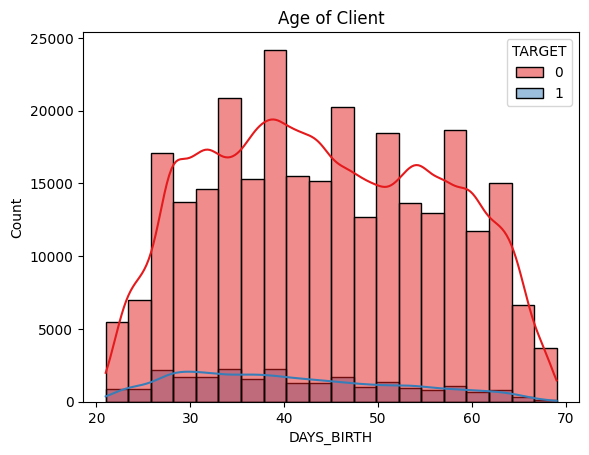

In [9]:
sns.histplot(data=df_train, x= round(df_train['DAYS_BIRTH']/-365), bins=20, kde=True, hue='TARGET', palette='Set1')
plt.title('Age of Client')
plt.show()

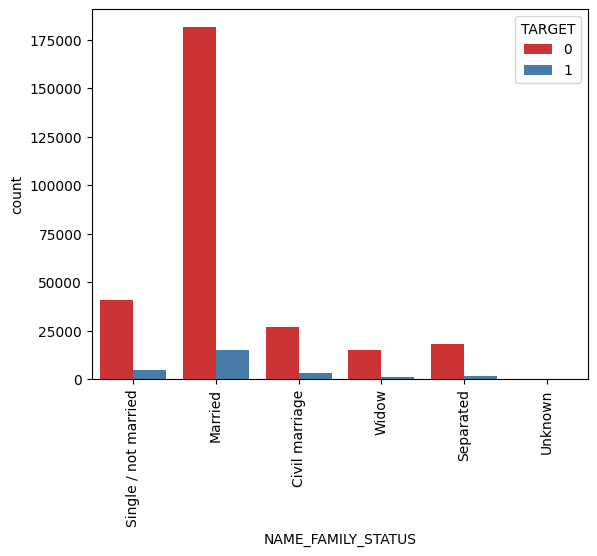

Gender Counts:
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


In [10]:
sns.countplot(data=df_train, x='NAME_FAMILY_STATUS', hue='TARGET', palette='Set1')
plt.xticks(rotation=90)
plt.show()
statusf_count = df_train['NAME_FAMILY_STATUS'].value_counts()
# Display the counts
print("Gender Counts:")
print(statusf_count)

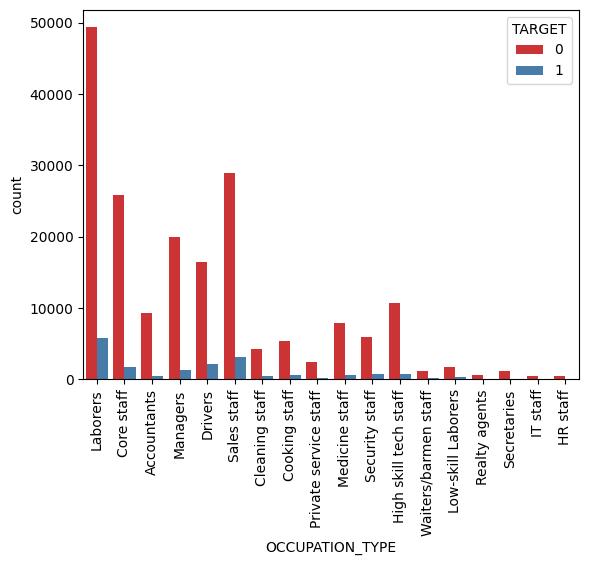

In [11]:
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=df_train,palette='Set1')
plt.xticks(rotation=90)
plt.show()

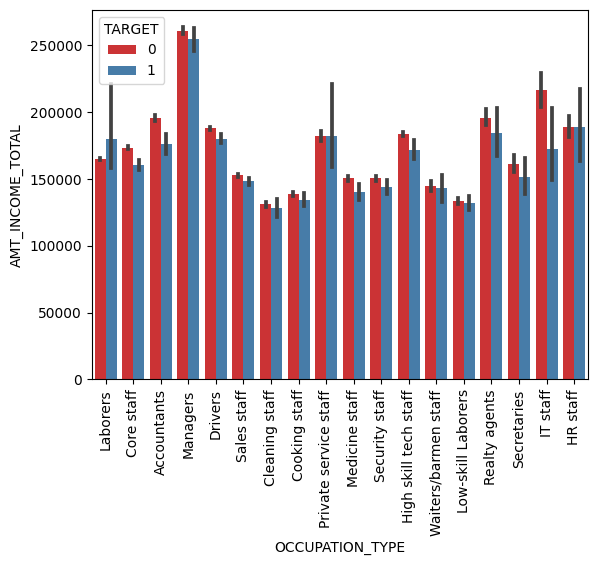

In [12]:
sns.barplot(x='OCCUPATION_TYPE',y='AMT_INCOME_TOTAL',data=df_train, hue="TARGET", palette='Set1')
plt.xticks(rotation=90)
plt.show()

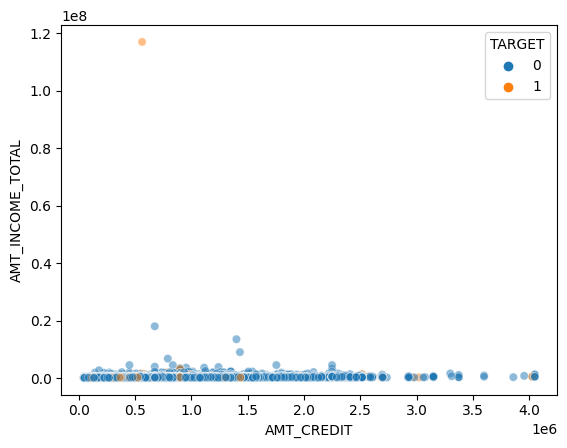

In [13]:
sns.scatterplot(x='AMT_CREDIT', y='AMT_INCOME_TOTAL', data=df_train, hue='TARGET', alpha=0.5)
plt.show()

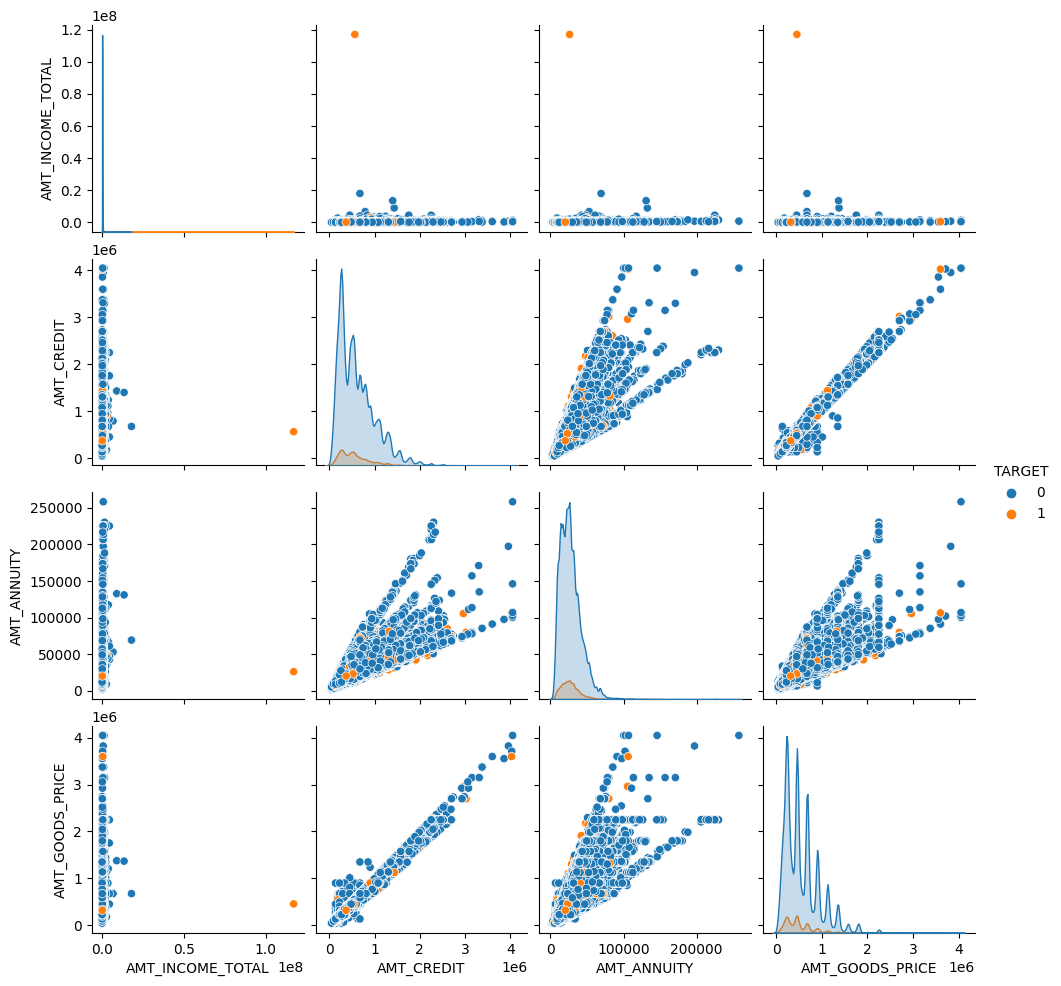

In [14]:
# SHOW CORRELATION BETWEEN TARGET to Income, Credit, Annuity, Goods Price
columns_to_visualize = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',]
sns.pairplot(df_train[columns_to_visualize + ['TARGET']], hue='TARGET')
plt.show()

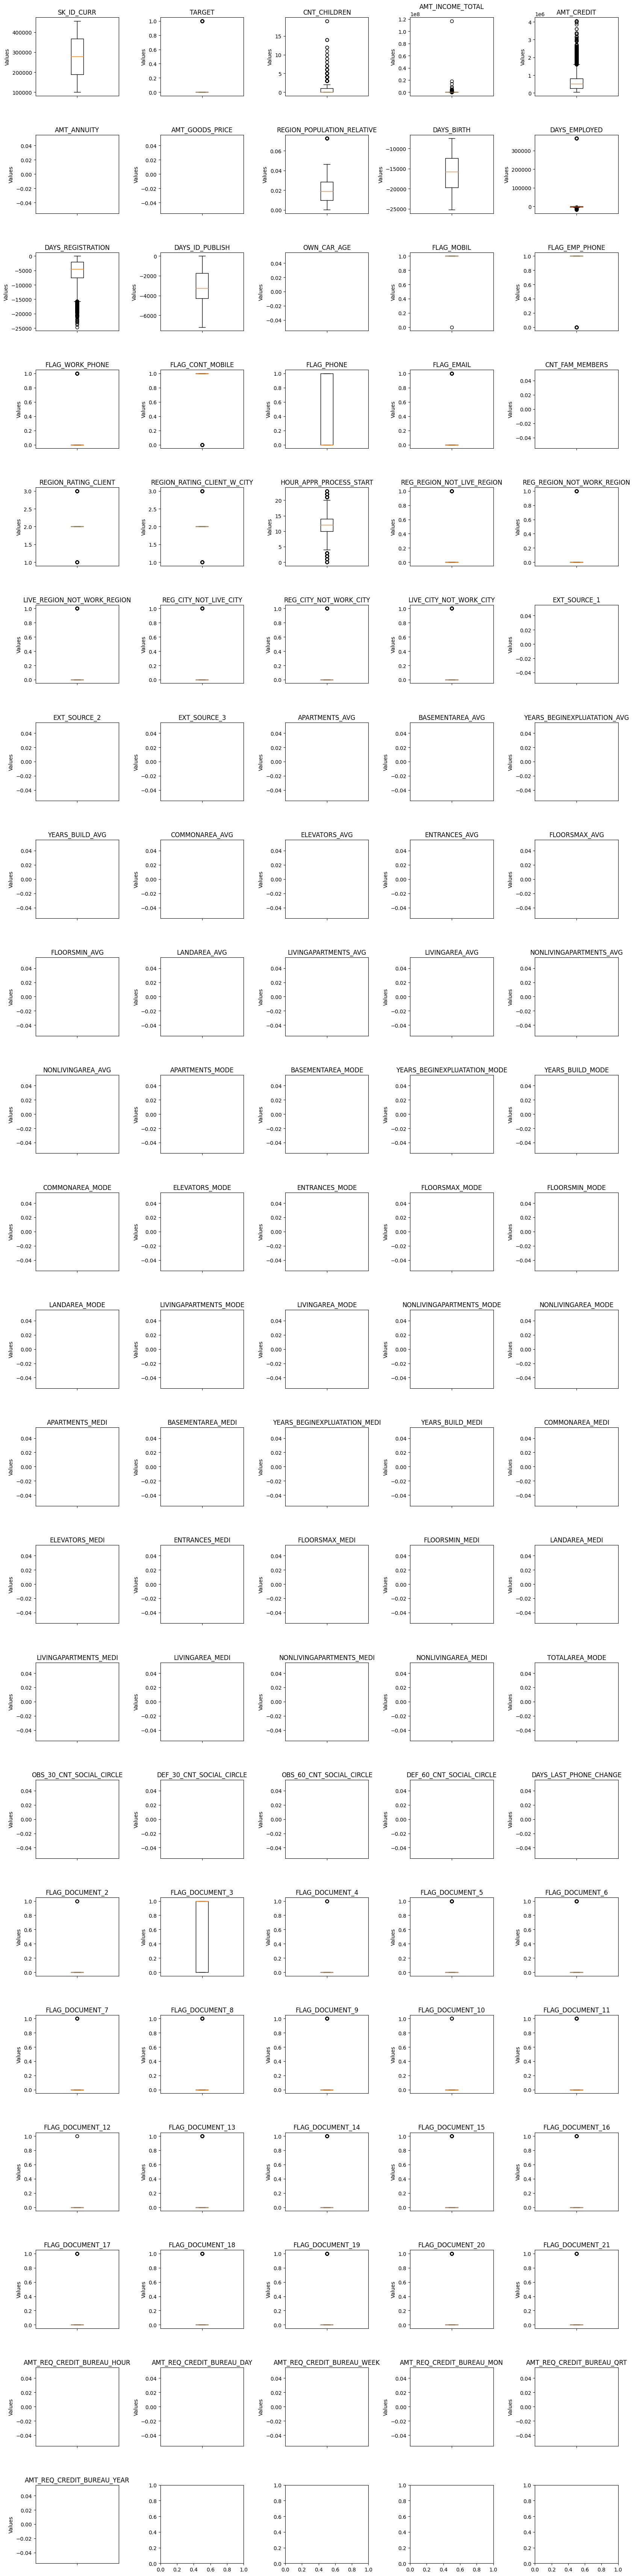

In [15]:
# CHECK _OUTLIERS_ IN NUMERIC COLUMNS
# Get numeric columns
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

# Calculate the number of subplots needed based on the number of numeric columns
num_subplots = len(numeric_columns)
num_cols_per_subplot = 5
num_rows = (num_subplots - 1) // num_cols_per_subplot + 1

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols_per_subplot, figsize=(20, 4 * num_rows))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axs = axs.ravel()

# Loop through numeric columns and create box plots
for i, col in enumerate(numeric_columns):
    axs[i].boxplot(df_train[col])
    axs[i].set_title(col)
    axs[i].set_xticklabels([])
    axs[i].set_ylabel('Values')

# Show plots
plt.show()




### PREPROCESSING TRAIN DATA & TEST DATA

#### FUCTION

In [16]:
# handling
# outlier
def outlier(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3-Q1
  df_final = df[~((df<(Q1-(1.5*IQR))) | (df>(Q3+(1.5*IQR))))]
  return df_final

#### CLEANSING

Replace NULL

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [18]:
print('Count Null Train',df_train.isna().sum().sum())
print('Count Null Test',df_test.isna().sum().sum())

Count Null Train 9152465
Count Null Test 1404419


In [19]:
## ** PREPROCESSING NULL VALUES TRAIN**
#DECLARE NUMERICAL AND CATEGORICAL COLUMNS
cat_col_train = df_train.select_dtypes(include=['object']).columns
num_col_train = df_train.select_dtypes(include=['int64', 'float64']).columns

#REPLACE NaN WITH MODE, when the data is categorical
# Impute missing values for categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_train[cat_col_train] = categorical_imputer.fit_transform(df_train[cat_col_train])

#REPLACE NaN WITH MEAN, when the data is numerical
# Impute missing values for numeric columns with median
numeric_imputer = SimpleImputer(strategy='median')
df_train[num_col_train] = numeric_imputer.fit_transform(df_train[num_col_train])

## ** PREPROCESSING NULL VALUES TRAIN**
#DECLARE NUMERICAL AND CATEGORICAL COLUMNS
cat_col_test = df_test.select_dtypes(include=['object']).columns
num_col_test = df_test.select_dtypes(include=['int64', 'float64']).columns

#REPLACE NaN WITH MODE, when the data is categorical
# Impute missing values for categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_test[cat_col_test] = categorical_imputer.fit_transform(df_test[cat_col_test])

#REPLACE NaN WITH MEAN, when the data is numerical
# Impute missing values for numeric columns with median
numeric_imputer = SimpleImputer(strategy='median')
df_test[num_col_test] = numeric_imputer.fit_transform(df_test[num_col_test])

In [20]:
print('Count Null Train',df_train.isna().sum().sum())
print('Count Null Test',df_test.isna().sum().sum())

Count Null Train 0
Count Null Test 0


In [21]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003.0,0.0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0.0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007.0,0.0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001.0,Cash loans,F,N,Y,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005.0,Cash loans,M,N,Y,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013.0,Cash loans,M,Y,Y,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028.0,Cash loans,F,N,Y,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038.0,Cash loans,M,Y,N,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Drop Duplicates

In [23]:
# Check If Duplicates Exist
print('Count Duplicates Train',df_train.duplicated().sum())
print('Count Duplicates Test',df_test.duplicated().sum())

Count Duplicates Train 0
Count Duplicates Test 0


Because the gender have 3 entity instead 2, we should drop entity XNA

#### ENCODING

Check Column with Categorical Data

In [24]:
# SHOW COLUMN WITH CATEGORICAL DATA
categorical_columns = df_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Column: {col}")
    print(f"Unique values: {df_train[col].unique()}")


Column: NAME_CONTRACT_TYPE
Unique values: ['Cash loans' 'Revolving loans']
Column: CODE_GENDER
Unique values: ['M' 'F' 'XNA']
Column: FLAG_OWN_CAR
Unique values: ['N' 'Y']
Column: FLAG_OWN_REALTY
Unique values: ['Y' 'N']
Column: NAME_TYPE_SUITE
Unique values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
Column: NAME_INCOME_TYPE
Unique values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
Column: NAME_EDUCATION_TYPE
Unique values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Column: NAME_FAMILY_STATUS
Unique values: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
Column: NAME_HOUSING_TYPE
Unique values: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
Column: OCCUPATION_TYPE
Unique values: ['Laborers' 

In [25]:
# SHOW COLUMN WITH NUMERICAL DATA
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    print(f"Column: {col}")


Column: SK_ID_CURR
Column: TARGET
Column: CNT_CHILDREN
Column: AMT_INCOME_TOTAL
Column: AMT_CREDIT
Column: AMT_ANNUITY
Column: AMT_GOODS_PRICE
Column: REGION_POPULATION_RELATIVE
Column: DAYS_BIRTH
Column: DAYS_EMPLOYED
Column: DAYS_REGISTRATION
Column: DAYS_ID_PUBLISH
Column: OWN_CAR_AGE
Column: FLAG_MOBIL
Column: FLAG_EMP_PHONE
Column: FLAG_WORK_PHONE
Column: FLAG_CONT_MOBILE
Column: FLAG_PHONE
Column: FLAG_EMAIL
Column: CNT_FAM_MEMBERS
Column: REGION_RATING_CLIENT
Column: REGION_RATING_CLIENT_W_CITY
Column: HOUR_APPR_PROCESS_START
Column: REG_REGION_NOT_LIVE_REGION
Column: REG_REGION_NOT_WORK_REGION
Column: LIVE_REGION_NOT_WORK_REGION
Column: REG_CITY_NOT_LIVE_CITY
Column: REG_CITY_NOT_WORK_CITY
Column: LIVE_CITY_NOT_WORK_CITY
Column: EXT_SOURCE_1
Column: EXT_SOURCE_2
Column: EXT_SOURCE_3
Column: APARTMENTS_AVG
Column: BASEMENTAREA_AVG
Column: YEARS_BEGINEXPLUATATION_AVG
Column: YEARS_BUILD_AVG
Column: COMMONAREA_AVG
Column: ELEVATORS_AVG
Column: ENTRANCES_AVG
Column: FLOORSMAX_AVG
C

Replace Cat to Num

In [26]:
# Replace categorical values with numerical labels (0, 1, 2)
for col in categorical_columns:
    df_train[col] = pd.Categorical(df_train[col])
    df_train[col] = df_train[col].cat.codes

# Columns to exclude from scaling
columns_to_exclude = ['SK_ID_CURR', 'TARGET']

# Apply StandardScaler to numeric columns (excluding specific columns)
scaler = StandardScaler()
for col in numeric_columns:
    if col not in columns_to_exclude:
        df_train[col] = scaler.fit_transform(df_train[[col]])

# Now 'df_train' contains numerical labels for categorical columns and normalized numeric columns, excluding specified columns from scaling


In [27]:
# Replace categorical values with numerical labels (0, 1, 2)
for col in categorical_columns:
    df_test[col] = pd.Categorical(df_test[col])
    df_test[col] = df_test[col].cat.codes

# Columns to exclude from scaling
columns_to_exclude = ['SK_ID_CURR', 'TARGET']

# Apply StandardScaler to numeric columns (excluding specific columns)
scaler = StandardScaler()
for col in numeric_columns:
    if col not in columns_to_exclude:
        df_test[col] = scaler.fit_transform(df_test[[col]])

# Now 'df_test' contains numerical labels for categorical columns and normalized numeric columns, excluding specified columns from scaling


In [28]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0,1,0,1,-0.577538,0.142129,-0.478095,-0.166143,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926
1,100003.0,0.0,0,0,0,0,-0.577538,0.426792,1.725450,0.592683,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331
2,100004.0,0.0,1,1,1,1,-0.577538,-0.427196,-1.152888,-1.404669,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331
3,100006.0,0.0,0,0,0,1,-0.577538,-0.142533,-0.711430,0.177874,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926
4,100007.0,0.0,0,1,0,1,-0.577538,-0.199466,-0.213734,-0.361749,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331


In [29]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001.0,0,0,0,1,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,-1.153865
1,100005.0,0,1,0,1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
2,100013.0,0,1,1,1,-0.559988,0.237075,0.401002,2.520066,0.497113,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,0.773588,1.170387
3,100028.0,0,0,0,1,2.260729,1.345214,2.896221,1.223666,3.303709,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
4,100038.0,0,1,1,0,0.850370,0.015447,0.297651,0.165019,0.483748,...,-0.039517,0.0,0.0,0.0,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.008261


Handle Outliers

In [30]:
# Columns to apply the outlier function to
columns_to_process = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED']

# Isolate the columns you want to process
selected_columns = df_train[columns_to_process]

# Apply the outlier function to selected columns
processed_columns = outlier(selected_columns)

# Replace the original columns with the processed columns
df_train[columns_to_process] = processed_columns
df_train.fillna(method='bfill',inplace=True)

#### HANDLING IMBALANCE DATA

Before we come further to feature selection we should handling the imbalance of the dataset

In [31]:
# Split the data into features (X_train) and target (y_train)
X_train = df_train.drop(['TARGET'], axis=1)
y_train = df_train['TARGET']

# Show Count of Target Variable
print('Target Variable Count:')
print(y_train.value_counts())

Target Variable Count:
0.0    282686
1.0     24825
Name: TARGET, dtype: int64


In [32]:
# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('After applying SMOTE:')
print(y_train_resampled.value_counts())

After applying SMOTE:
1.0    282686
0.0    282686
Name: TARGET, dtype: int64


#### FEATURE SELECTION

After we handling the imbalance data we need to check correlation 120 column to target, and pick which one had better correlation using SelectKBest f Classif

In [33]:
# Number of features to select
num_features_to_select = 60

# Initialize the SelectKBest feature selector using f_classif score function
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit the selector on the resampled training data and transform the features
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Transform the test data using the same selector
X_test_selected = selector.transform(df_test)

# Create DataFrames with selected features for both training and testing data
selected_features_train = X_train.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features_train)

selected_features_test = X_train.columns[selector.get_support()]
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features_test)

# Append the target column back to the selected training data
X_train_selected_df['TARGET'] = y_train

# Now you have DataFrames with selected features and the target column
X_train_selected_df.head()


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,...,FONDKAPREMONT_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,TARGET
0,0.0,1.0,0.0,1.0,-0.478095,-0.507236,7.0,4.0,3.0,-0.149452,...,2.0,-0.902008,5.0,0.0,4.163504,5.253260,-0.206992,0.639065,-0.310738,1.0
1,0.0,0.0,0.0,0.0,1.725450,1.600873,4.0,1.0,1.0,-1.252750,...,2.0,-0.187810,0.0,0.0,-0.320480,-0.275663,0.163107,0.639065,-0.310738,0.0
2,1.0,1.0,1.0,1.0,-1.152888,-1.092145,7.0,4.0,3.0,-0.783451,...,2.0,-0.220676,4.0,0.0,-0.320480,-0.275663,0.178831,-1.564786,-0.310738,0.0
3,0.0,0.0,0.0,1.0,-0.711430,-0.653463,7.0,4.0,0.0,-0.928991,...,2.0,-0.220676,4.0,0.0,-0.320480,-0.275663,0.418306,0.639065,-0.310738,0.0
4,0.0,1.0,0.0,1.0,-0.213734,-0.068554,7.0,4.0,3.0,0.563570,...,2.0,-0.220676,4.0,0.0,-0.320480,-0.275663,-0.173126,-1.564786,-0.310738,0.0


#### SPLIT DATA TRAIN & VAL

In [34]:
# Split the resampled training data into train and validation sets
X_train_selected_split, X_val_selected, y_train_split, y_val = train_test_split(
    X_train_selected, y_train_resampled, test_size=0.2, random_state=42
)
# record stats
print(f"Training Records = {X_train_selected_split.shape[0]} ; Validation Record {X_val_selected.shape[0]} ; Testing Record {X_test_selected.shape[0]}")


Training Records = 452297 ; Validation Record 113075 ; Testing Record 48744


### MODEL TRAINING

Logistic Regression

In [35]:
#Hyperparameter Tuning
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected_split, y_train_split)
# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)
best_logreg = grid_search.best_estimator_

# Make predictions on the test data
y_test_pred = best_logreg.predict(X_test_scaled)


In [ ]:
# Train a LogisticRegression model on the selected features
logreg_classifier = LogisticRegression(random_state=42,C=0.1,penalty='l1',solver='liblinear', max_iter=100,
                                       class_weight='balanced')
logreg_classifier.fit(X_train_selected_split, y_train_split)

# Make predictions on the test data
y_test_pred = logreg_classifier.predict(X_test_selected)

In [ ]:
# Make predictions on the validation set
y_val_pred = logreg_classifier.predict(X_val_selected)

# Calculate accuracy, precision, recall, and F1 score on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Accuracy: 0.76
Precision: 0.75
Recall: 0.77
F1 Score: 0.76


Confusion Matrix:
[[41789 14747]
 [12751 43788]]


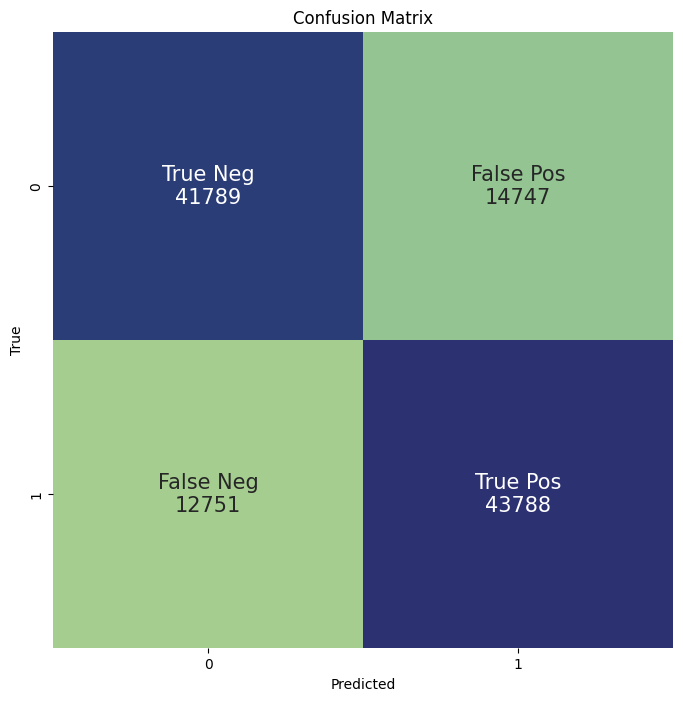

In [ ]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix, annot=labels, cmap='crest', cbar=False, fmt='', annot_kws={"size": 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Define class names if applicable
class_names = ["Class 0", "Class 1"]

# Display classification report
class_report = classification_report(y_val, y_val_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.74      0.75     56536
     Class 1       0.75      0.77      0.76     56539

    accuracy                           0.76    113075
   macro avg       0.76      0.76      0.76    113075
weighted avg       0.76      0.76      0.76    113075



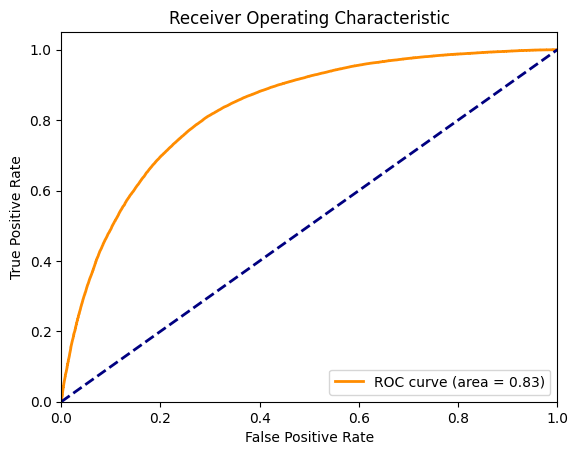

In [ ]:
# y_scores = log.decision_function(X_test_selected)
y_scores = logreg_classifier.predict_proba(X_val_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Random Forrest

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the RandomForestClassifier
# rf_classifier = RandomForestClassifier(random_state=42)

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
# grid_search.fit(X_train_selected_split, y_train_split)

# # Get the best RandomForestClassifier model from the grid search
# best_rf_classifier = grid_search.best_estimator_

# # Make predictions on the test data using the best model
# y_test_pred = best_rf_classifier.predict(X_test_selected)

In [ ]:
# Train a RandomForestClassifier on the selected features
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_selected_split, y_train_split)

# Make predictions on the test data
y_test_pred = rf_classifier.predict(X_test_selected)

In [ ]:
# Make predictions on the validation set
y_val_pred = rf_classifier.predict(X_val_selected)

# Calculate accuracy, precision, recall, and F1 score on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Accuracy: 0.95
Precision: 1.00
Recall: 0.91
F1 Score: 0.95


Confusion Matrix:
[[56357   179]
 [ 5276 51263]]


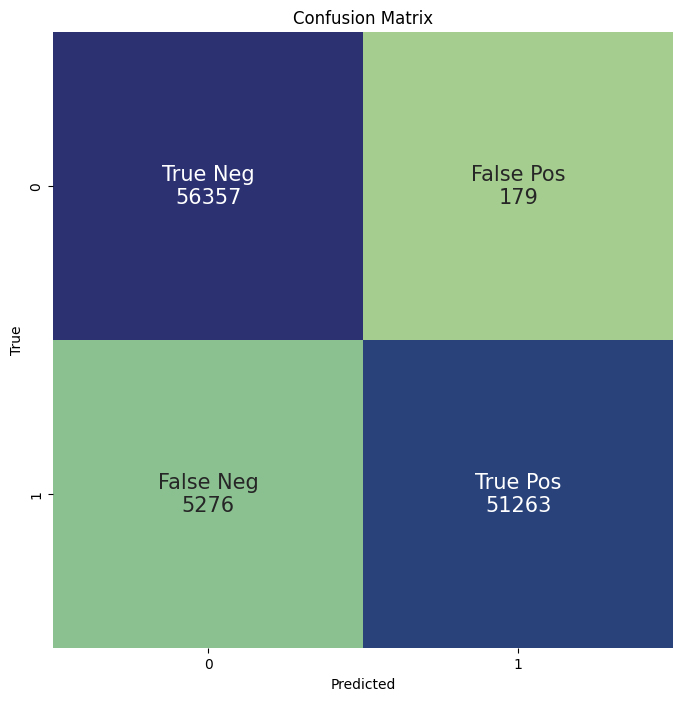

In [ ]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(conf_matrix, annot=labels, cmap='crest', cbar=False, fmt='', annot_kws={"size": 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Define class names if applicable
class_names = ["Class 0", "Class 1"]

# Display classification report
class_report = classification_report(y_val, y_val_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95     56536
     Class 1       1.00      0.91      0.95     56539

    accuracy                           0.95    113075
   macro avg       0.96      0.95      0.95    113075
weighted avg       0.96      0.95      0.95    113075



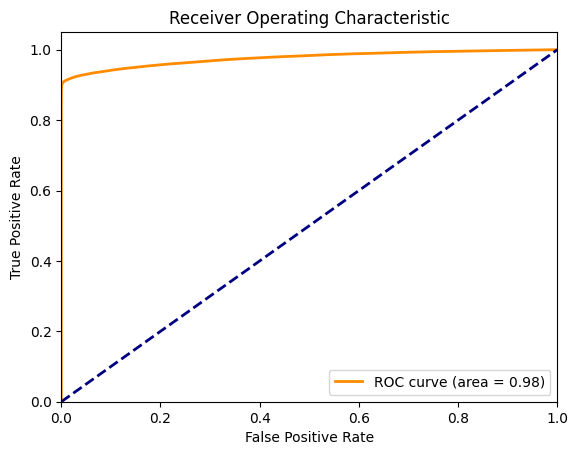

In [ ]:
# y_scores = log.decision_function(X_test_selected)
y_scores = rf_classifier.predict_proba(X_val_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

KERAS MLP - NEURAL NETWORK

X_train_selected_split, X_val_selected, y_train_split, y_val = train_test_split(
    X_train_selected, y_train_resampled, test_size=0.2, random_state=42
)

In [ ]:
# define model params
input_shape = X_train_selected_split.shape[1]                                                         
output_shape = y_train_split.shape[1]                                                           
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)                         
batch_size = np.ceil(len(X_train_selected_split) / 128).astype(int)                                     

# build model
model = models.Sequential()
# input layer
model.add(layers.Dense(
                        batch_size
                       ,input_shape=(input_shape,)
                       ,name='input_layer'
                       ,activation='selu'))
# hidden layer
model.add(layers.Dense(
                        nodes
                        ,name='hidden_nides'
                       ,activation='selu'))
# dropout layer
model.add(layers.Dropout(0.5))

# output layer
model.add(layers.Dense(
                        output_shape
                        ,name='output_layer'
                       ,activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summmary
model.summary()


IndexError: tuple index out of range

In [ ]:
# model fit params
epoch = 200

# garbage collect, incase we're re-running the model to get the best fit
gc.collect()
    
# reset model , incase we're re-running the model to get the best fit
clear_session()

# fit the keras model on the dataset
hist = model.fit(X_train_selected_split
                  ,y_train_split
                  ,epochs = epoch
                  ,batch_size=batch_size
                  ,shuffle=True
                  ,validation_data=(X_val_selected, y_val)
                  ,verbose=0
                  ,callbacks=[TqdmCallback(verbose=0)]
          )


In [ ]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val_selected)
y_val_pred_class = np.argmax(y_val_pred, axis=1)  # Convert probability scores to class predictions

# Calculate accuracy, precision, recall, and F1 score on the validation set
accuracy = accuracy_score(y_val, y_val_pred_class)
precision = precision_score(y_val, y_val_pred_class)
recall = recall_score(y_val, y_val_pred_class)
f1 = f1_score(y_val, y_val_pred_class)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
# visualize training results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()